#Instalasi Pustaka

In [24]:
!pip install catboost optuna imbalanced-learn optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.4 MB/s eta 0:00:00


#Mount Drive & Memuat Data

In [14]:
# Cell 2: Mount Drive dan Load Dataset
from google.colab import drive
import pandas as pd
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Definisi Lokasi File (SESUAIKAN PATH INI DENGAN FOLDER ANDA)
base_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/'

# Path file sesuai nama standar dataset UNSW-NB15
train_path = os.path.join(base_path, 'UNSW_NB15_training-set.csv')
test_path = os.path.join(base_path, 'UNSW_NB15_testing-set.csv')

# 3. Memuat Data
try:
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    print("✅ Dataset berhasil dimuat.")
    print(f"Data Latih: {df_train.shape}")
    print(f"Data Uji: {df_test.shape}")
except FileNotFoundError:
    print("❌ Error: File tidak ditemukan. Periksa kembali path folder Anda.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset berhasil dimuat.
Data Latih: (175341, 45)
Data Uji: (82332, 45)


#Seleksi Fitur (Data Selection)

In [15]:
# Cell 3: Seleksi Fitur
# Menghapus kolom identifier dan waktu sesuai Bab 3.2.2
cols_to_drop = ['id', 'srcip', 'dstip', 'stime', 'ltime']

df_train = df_train.drop(columns=cols_to_drop, errors='ignore')
df_test = df_test.drop(columns=cols_to_drop, errors='ignore')

# Menghapus kolom 'label' (biner) karena kita fokus pada multiclass 'attack_cat'
if 'label' in df_train.columns:
    df_train.drop(columns=['label'], inplace=True)
if 'label' in df_test.columns:
    df_test.drop(columns=['label'], inplace=True)

print("Seleksi fitur selesai.")
print(f"Kolom tersisa: {len(df_train.columns)}")

Seleksi fitur selesai.
Kolom tersisa: 43


#Pra-pemrosesan (Encoding & Splitting)

In [16]:
# Cell 4: Encoding & Pemisahan X/y
from sklearn.preprocessing import LabelEncoder

# 1. Encoding Target (attack_cat)
le_target = LabelEncoder()
df_train['attack_cat'] = le_target.fit_transform(df_train['attack_cat'])
df_test['attack_cat'] = le_target.transform(df_test['attack_cat'])

# Mapping label untuk referensi
print("Mapping Kelas Serangan:", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

# 2. Identifikasi Kolom Numerik dan Kategorikal
X_train_raw = df_train.drop(columns=['attack_cat'])
y_train = df_train['attack_cat']
X_test_raw = df_test.drop(columns=['attack_cat'])
y_test = df_test['attack_cat']

cat_cols = X_train_raw.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. Encoding Fitur Kategorikal (Input X)
# Kita simpan encoder agar bisa dipakai ulang
feature_encoders = {}
X_train_enc = X_train_raw.copy()
X_test_enc = X_test_raw.copy()

for col in cat_cols:
    le = LabelEncoder()
    # Fit pada gabungan train+test agar semua kategori tercover
    combined = pd.concat([X_train_raw[col], X_test_raw[col]], axis=0).astype(str)
    le.fit(combined)

    X_train_enc[col] = le.transform(X_train_raw[col].astype(str))
    X_test_enc[col] = le.transform(X_test_raw[col].astype(str))
    feature_encoders[col] = le

# Simpan indeks kolom kategorikal untuk SMOTE-NC
cat_features_indices = [X_train_enc.columns.get_loc(c) for c in cat_cols]
print(f"Indeks Fitur Kategorikal: {cat_features_indices}")

Mapping Kelas Serangan: {'Analysis': np.int64(0), 'Backdoor': np.int64(1), 'DoS': np.int64(2), 'Exploits': np.int64(3), 'Fuzzers': np.int64(4), 'Generic': np.int64(5), 'Normal': np.int64(6), 'Reconnaissance': np.int64(7), 'Shellcode': np.int64(8), 'Worms': np.int64(9)}
Indeks Fitur Kategorikal: [1, 2, 3]


##Standarisasi Fitur Numerik

In [17]:
# Cell 5: Standarisasi (Z-Score)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit hanya pada Data Latih
scaler.fit(X_train_enc[num_cols])

# Transform Data Latih dan Data Uji
X_train_enc[num_cols] = scaler.transform(X_train_enc[num_cols])
X_test_enc[num_cols] = scaler.transform(X_test_enc[num_cols])

print("Standarisasi selesai. Rata-rata fitur numerik data latih mendekati 0.")

Standarisasi selesai. Rata-rata fitur numerik data latih mendekati 0.


##Resampling (SMOTE-ENN)

In [19]:
# Cell 6: Eksekusi SMOTE-ENN
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC

print("Memulai Resampling SMOTE-ENN... (Mohon tunggu, proses ini cukup lama)")

# PERBAIKAN: Menghapus 'n_jobs=-1' dari SMOTENC karena tidak didukung di versi baru
smote_nc = SMOTENC(categorical_features=cat_features_indices, random_state=42)

# SMOTE-ENN: Gabungan SMOTE-NC dan ENN cleaning
# Kita pindahkan n_jobs ke sini (jika didukung) atau biarkan default agar aman
smote_enn = SMOTEENN(smote=smote_nc, random_state=42)

# Fit Resample (Hanya pada Data Latih)
try:
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_enc, y_train)
    print("✅ Resampling Selesai!")
    print(f"Data Latih Awal: {X_train_enc.shape}")
    print(f"Data Latih Resampled: {X_train_resampled.shape}")
except Exception as e:
    print(f"Terjadi kesalahan saat resampling: {e}")

Memulai Resampling SMOTE-ENN... (Mohon tunggu, proses ini cukup lama)
✅ Resampling Selesai!
Data Latih Awal: (175341, 42)
Data Latih Resampled: (378848, 42)


In [20]:
# Cell Tambahan: Export Data Resampled ke CSV
import os

# 1. Gabungkan Fitur (X) dan Target (y) menjadi satu DataFrame
# Kita copy dulu agar aman
df_resampled_export = X_train_resampled.copy()

# Masukkan kembali kolom target 'attack_cat'
df_resampled_export['attack_cat'] = y_train_resampled

# 2. Tentukan Lokasi Penyimpanan (di folder yang sama dengan dataset asli)
# Nama file: UNSW_NB15_training_resampled_SMOTEENN.csv
save_path = os.path.join(base_path, 'UNSW_NB15_training_resampled_SMOTEENN.csv')

# 3. Simpan ke CSV
print(f"Sedang menyimpan data ke: {save_path} ...")
df_resampled_export.to_csv(save_path, index=False)

print("✅ BERHASIL: Data Resampled telah disimpan di Google Drive Anda.")
print(f"Ukuran Data: {df_resampled_export.shape}")

Sedang menyimpan data ke: /content/drive/MyDrive/Colab Notebooks/Dataset/UNSW_NB15_training_resampled_SMOTEENN.csv ...
✅ BERHASIL: Data Resampled telah disimpan di Google Drive Anda.
Ukuran Data: (378848, 43)


JIKA DIBUTUHKAN SAJA

In [ ]:
# [OPSIONAL] Kode untuk LOAD data resampled (Hanya dipakai jika restart sesi)
# Ganti Cell 6 dengan ini jika file resampled sudah ada di Drive:

resampled_path = os.path.join(base_path, 'UNSW_NB15_training_resampled_SMOTEENN.csv')

if os.path.exists(resampled_path):
    print("Memuat data resampled dari Drive...")
    df_resampled = pd.read_csv(resampled_path)

    # Pisahkan lagi jadi X dan y
    y_train_resampled = df_resampled['attack_cat']
    X_train_resampled = df_resampled.drop(columns=['attack_cat'])
    print("Data Resampled berhasil dimuat!")
else:
    print("File tidak ditemukan, jalankan proses SMOTE-ENN dari awal.")

##Validasi Visualisasi Data

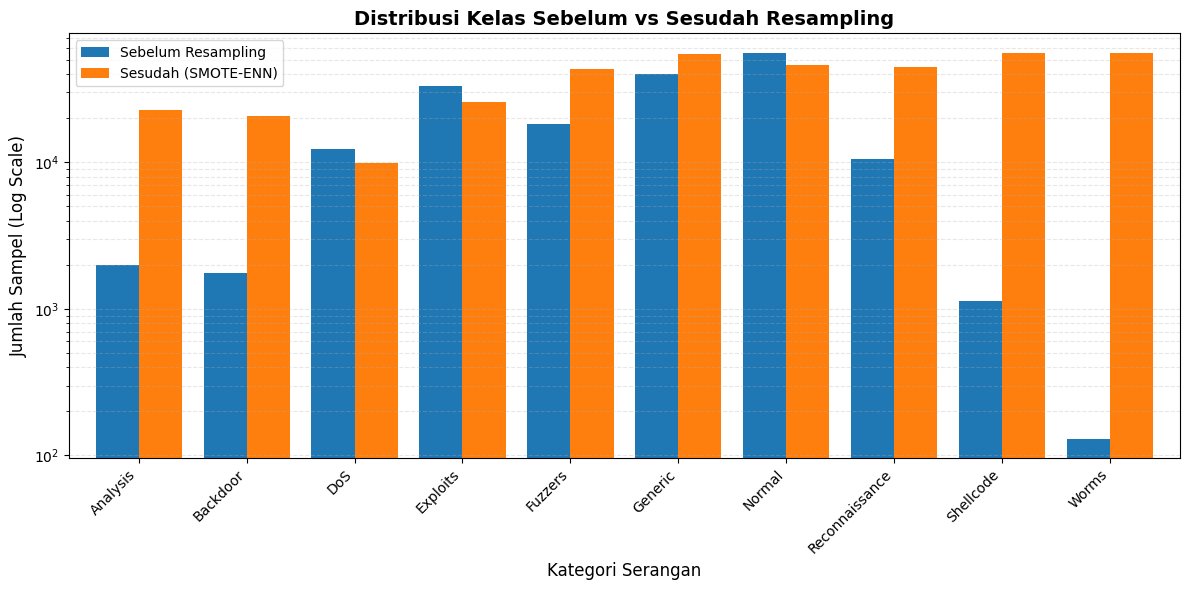

Detail Jumlah Sampel:


,Sebelum Resampling,Sesudah (SMOTE-ENN)
Analysis,2000,22614
Backdoor,1746,20795
DoS,12264,9889
Exploits,33393,25606
Fuzzers,18184,43532
Generic,40000,54840
Normal,56000,46224
Reconnaissance,10491,44704
Shellcode,1133,55320
Worms,130,55324


In [47]:
# Cell 7: Visualisasi Distribusi Kelas (Dengan Label Nama)
import matplotlib.pyplot as plt
import pandas as pd

# 1. Hitung distribusi berdasarkan index angka (0, 1, 2...)
dist_awal = y_train.value_counts().sort_index()
dist_akhir = y_train_resampled.value_counts().sort_index()

# 2. Buat DataFrame untuk Plotting
df_plot = pd.DataFrame({
    'Sebelum Resampling': dist_awal,
    'Sesudah (SMOTE-ENN)': dist_akhir
})

# --- BAGIAN REVISI: Mengubah Index Angka ke Nama Kelas ---
# Kita ambil nama kelas asli dari LabelEncoder yang dibuat di Cell 4
if 'le_target' in locals():
    df_plot.index = le_target.classes_
else:
    print("Warning: le_target tidak ditemukan, menggunakan index angka.")

# 3. Plotting
ax = df_plot.plot(kind='bar', figsize=(12, 6), logy=True, width=0.8)

plt.title("Distribusi Kelas Sebelum vs Sesudah Resampling", fontsize=14, fontweight='bold')
plt.ylabel("Jumlah Sampel (Log Scale)", fontsize=12)
plt.xlabel("Kategori Serangan", fontsize=12)

# Mengatur rotasi label agar terbaca jelas
plt.xticks(rotation=45, ha='right')

# Menambahkan Grid tipis agar mudah dibaca
plt.grid(axis='y', linestyle='--', alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Tampilkan tabel angkanya juga agar detail
print("Detail Jumlah Sampel:")
display(df_plot)

#Transformasi Data

##Optimasi Skenario 1 - TPE

In [33]:
# Cell 8: Optimasi TPE (Bayesian)
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def objective_tpe(trial):
    # Ruang Pencarian (Search Space) sesuai Tabel 3.4
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'iterations': trial.suggest_int('iterations', 500, 1500),

        # Parameter Statis & GPU
        'loss_function': 'MultiClass',
        'task_type': 'GPU',
        'devices': '0',
        'verbose': False,
        'random_seed': 42
    }

    # Split validasi internal untuk TPE (tetap butuh validasi untuk skor F1)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

    model = CatBoostClassifier(**param)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=50)

    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

# Membuat Study TPE
print("Memulai Optimasi TPE...")
study_tpe = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_tpe.optimize(objective_tpe, n_trials=30) # Sesuaikan n_trials (misal 30 atau 50)

print("Best Params TPE:", study_tpe.best_params)

[I 2025-12-29 09:53:08,659] A new study created in memory with name: no-name-5afe798c-6232-4b3d-ae53-5cdfa6d1265a


Memulai Optimasi TPE...


[I 2025-12-29 09:53:54,177] Trial 0 finished with value: 0.9174028200048896 and parameters: {'learning_rate': 0.03574712922600244, 'depth': 10, 'l2_leaf_reg': 7.587945476302646, 'random_strength': 5.986584841970366, 'bagging_temperature': 0.15601864044243652, 'iterations': 656}. Best is trial 0 with value: 0.9174028200048896.
[I 2025-12-29 09:55:21,224] Trial 1 finished with value: 0.907371398784905 and parameters: {'learning_rate': 0.012184186502221764, 'depth': 10, 'l2_leaf_reg': 6.41003510568888, 'random_strength': 7.080725777960454, 'bagging_temperature': 0.020584494295802447, 'iterations': 1470}. Best is trial 0 with value: 0.9174028200048896.
[I 2025-12-29 09:55:39,656] Trial 2 finished with value: 0.9396153583664388 and parameters: {'learning_rate': 0.16967533607196555, 'depth': 5, 'l2_leaf_reg': 2.636424704863906, 'random_strength': 1.8340450985343382, 'bagging_temperature': 0.3042422429595377, 'iterations': 1025}. Best is trial 2 with value: 0.9396153583664388.
[I 2025-12-29 0

Best Params TPE: {'learning_rate': 0.18792686459303656, 'depth': 10, 'l2_leaf_reg': 3.2688758062660317, 'random_strength': 1.0113737263922675, 'bagging_temperature': 0.22689416828516545, 'iterations': 1281}


##Optimasi Skenario 2 - Hyperband

In [34]:
# Cell 9: Optimasi Hyperband (GPU Retrain Strategy)
# SOLUSI: Karena GPU tidak bisa 'resume' training, kita train ulang dari 0 di setiap checkpoint.
# KEUNTUNGAN: Tetap menggunakan kecepatan GPU yang masif + Logika Pruning Hyperband.

import optuna
import numpy as np
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

def objective_hb_gpu_final(trial):
    # 1. Definisi Parameter
    # Kita set range iterasi
    n_iterations = trial.suggest_int('iterations', 500, 1500)

    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),

        # GPU CONFIG
        'loss_function': 'MultiClass',
        'task_type': 'GPU',
        'devices': '0',
        'verbose': False,
        'random_seed': 42
    }

    # Split Validasi
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

    # 2. KONSEP "RETRAIN CHECKPOINT"
    # Kita bagi menjadi 4 titik pengecekan (Checkpoints)
    # Contoh: Jika iterasi 1000, kita cek di 250, 500, 750, 1000
    n_checkpoints = 4
    checkpoints = np.linspace(n_iterations // n_checkpoints, n_iterations, n_checkpoints, dtype=int)

    current_f1 = 0

    for step_iter in checkpoints:
        # Update jumlah iterasi di parameter
        param['iterations'] = int(step_iter)

        # --- PERUBAHAN UTAMA DI SINI ---
        # Kita buat model BARU setiap loop, tanpa init_model.
        # GPU sangat cepat, jadi retraining dari 0-500 tidak masalah demi kestabilan.
        model = CatBoostClassifier(**param)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        # 3. Hitung Score & Lapor ke Optuna
        preds = model.predict(X_val)
        current_f1 = f1_score(y_val, preds, average='macro')

        # Lapor: "Di step ke-sekian, skornya sekian"
        trial.report(current_f1, step_iter)

        # 4. Pruning Logic
        # Optuna akan membandingkan: "Apakah skor di step 250 ini lebih buruk dari trial lain?"
        # Jika ya, hentikan loop (hemat waktu agar tidak perlu train sampai 1000)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return current_f1

print("Memulai Optimasi Hyperband (Final GPU Strategy)...")

study_hb = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=HyperbandPruner(min_resource=1, max_resource='auto', reduction_factor=3)
)

# Jalankan 20-30 trials
study_hb.optimize(objective_hb_gpu_final, n_trials=30)

print("Best Params Hyperband:", study_hb.best_params)

[I 2025-12-29 10:17:18,814] A new study created in memory with name: no-name-23175fdd-ee23-4e39-99f2-42fa1b72bbb4


Memulai Optimasi Hyperband (Final GPU Strategy)...


[I 2025-12-29 10:19:11,710] Trial 0 finished with value: 0.9659494211647539 and parameters: {'iterations': 874, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 6.387926357773329, 'random_strength': 1.5601864044243652, 'bagging_temperature': 0.15599452033620265}. Best is trial 0 with value: 0.9659494211647539.
[I 2025-12-29 10:20:07,651] Trial 1 finished with value: 0.9476973519016123 and parameters: {'iterations': 558, 'learning_rate': 0.19030368381735815, 'depth': 8, 'l2_leaf_reg': 7.372653200164409, 'random_strength': 0.20584494295802447, 'bagging_temperature': 0.9699098521619943}. Best is trial 0 with value: 0.9659494211647539.
[I 2025-12-29 10:20:14,986] Trial 2 pruned. 
[I 2025-12-29 10:20:25,113] Trial 3 pruned. 
[I 2025-12-29 10:21:15,025] Trial 4 finished with value: 0.9301272536989542 and parameters: {'iterations': 956, 'learning_rate': 0.14447746112718687, 'depth': 5, 'l2_leaf_reg': 5.628109945722504, 'random_strength': 5.924145688620425, 'bagging_temperature'

Best Params Hyperband: {'iterations': 729, 'learning_rate': 0.28320024065521604, 'depth': 10, 'l2_leaf_reg': 7.786260475007547, 'random_strength': 8.246322255219809, 'bagging_temperature': 0.3125899596092543}


#Data Mining

##Evaluasi Model Akhir (Jalur TPE)

In [35]:
# Cell 10: Evaluasi Jalur TPE
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

# Ambil parameter terbaik TPE
best_params_tpe = study_tpe.best_params.copy()
best_params_tpe.update({'loss_function': 'MultiClass', 'task_type': 'GPU', 'devices': '0', 'random_seed': 42})

# Training Ulang
print("Melatih Model Final TPE...")
final_model_tpe = CatBoostClassifier(**best_params_tpe)
final_model_tpe.fit(X_train_resampled, y_train_resampled, verbose=0)

# Prediksi Data Uji
y_pred_tpe = final_model_tpe.predict(X_test_enc)

# Laporan
print("\n--- LAPORAN KINERJA METODE TPE ---")
print(classification_report(y_test, y_pred_tpe, target_names=le_target.classes_))
f1_tpe = f1_score(y_test, y_pred_tpe, average='macro')
print(f"Macro F1-Score (TPE): {f1_tpe:.4f}")

Melatih Model Final TPE...

--- LAPORAN KINERJA METODE TPE ---
                precision    recall  f1-score   support

      Analysis       0.05      0.30      0.08       677
      Backdoor       0.05      0.58      0.10       583
           DoS       0.40      0.13      0.19      4089
      Exploits       0.78      0.59      0.68     11132
       Fuzzers       0.24      0.65      0.35      6062
       Generic       1.00      0.96      0.98     18871
        Normal       0.99      0.59      0.74     37000
Reconnaissance       0.85      0.82      0.83      3496
     Shellcode       0.17      0.89      0.29       378
         Worms       0.24      0.64      0.35        44

      accuracy                           0.67     82332
     macro avg       0.48      0.62      0.46     82332
  weighted avg       0.86      0.67      0.72     82332

Macro F1-Score (TPE): 0.4600


##Evaluasi Model Akhir (Jalur Hyperband)

In [36]:
# Cell 11: Evaluasi Jalur Hyperband

# Ambil parameter terbaik Hyperband
best_params_hb = study_hb.best_params.copy()
best_params_hb.update({'loss_function': 'MultiClass', 'task_type': 'GPU', 'devices': '0', 'random_seed': 42})

# Training Ulang
print("Melatih Model Final Hyperband...")
final_model_hb = CatBoostClassifier(**best_params_hb)
final_model_hb.fit(X_train_resampled, y_train_resampled, verbose=0)

# Prediksi Data Uji
y_pred_hb = final_model_hb.predict(X_test_enc)

# Laporan
print("\n--- LAPORAN KINERJA METODE HYPERBAND ---")
print(classification_report(y_test, y_pred_hb, target_names=le_target.classes_))
f1_hb = f1_score(y_test, y_pred_hb, average='macro')
print(f"Macro F1-Score (Hyperband): {f1_hb:.4f}")

Melatih Model Final Hyperband...

--- LAPORAN KINERJA METODE HYPERBAND ---
                precision    recall  f1-score   support

      Analysis       0.04      0.26      0.07       677
      Backdoor       0.06      0.61      0.10       583
           DoS       0.37      0.13      0.20      4089
      Exploits       0.77      0.59      0.67     11132
       Fuzzers       0.24      0.64      0.35      6062
       Generic       1.00      0.96      0.98     18871
        Normal       0.99      0.59      0.74     37000
Reconnaissance       0.84      0.83      0.84      3496
     Shellcode       0.17      0.91      0.28       378
         Worms       0.22      0.70      0.34        44

      accuracy                           0.67     82332
     macro avg       0.47      0.62      0.46     82332
  weighted avg       0.85      0.67      0.72     82332

Macro F1-Score (Hyperband): 0.4561


#Analisis Perbandingan (Komparatif)

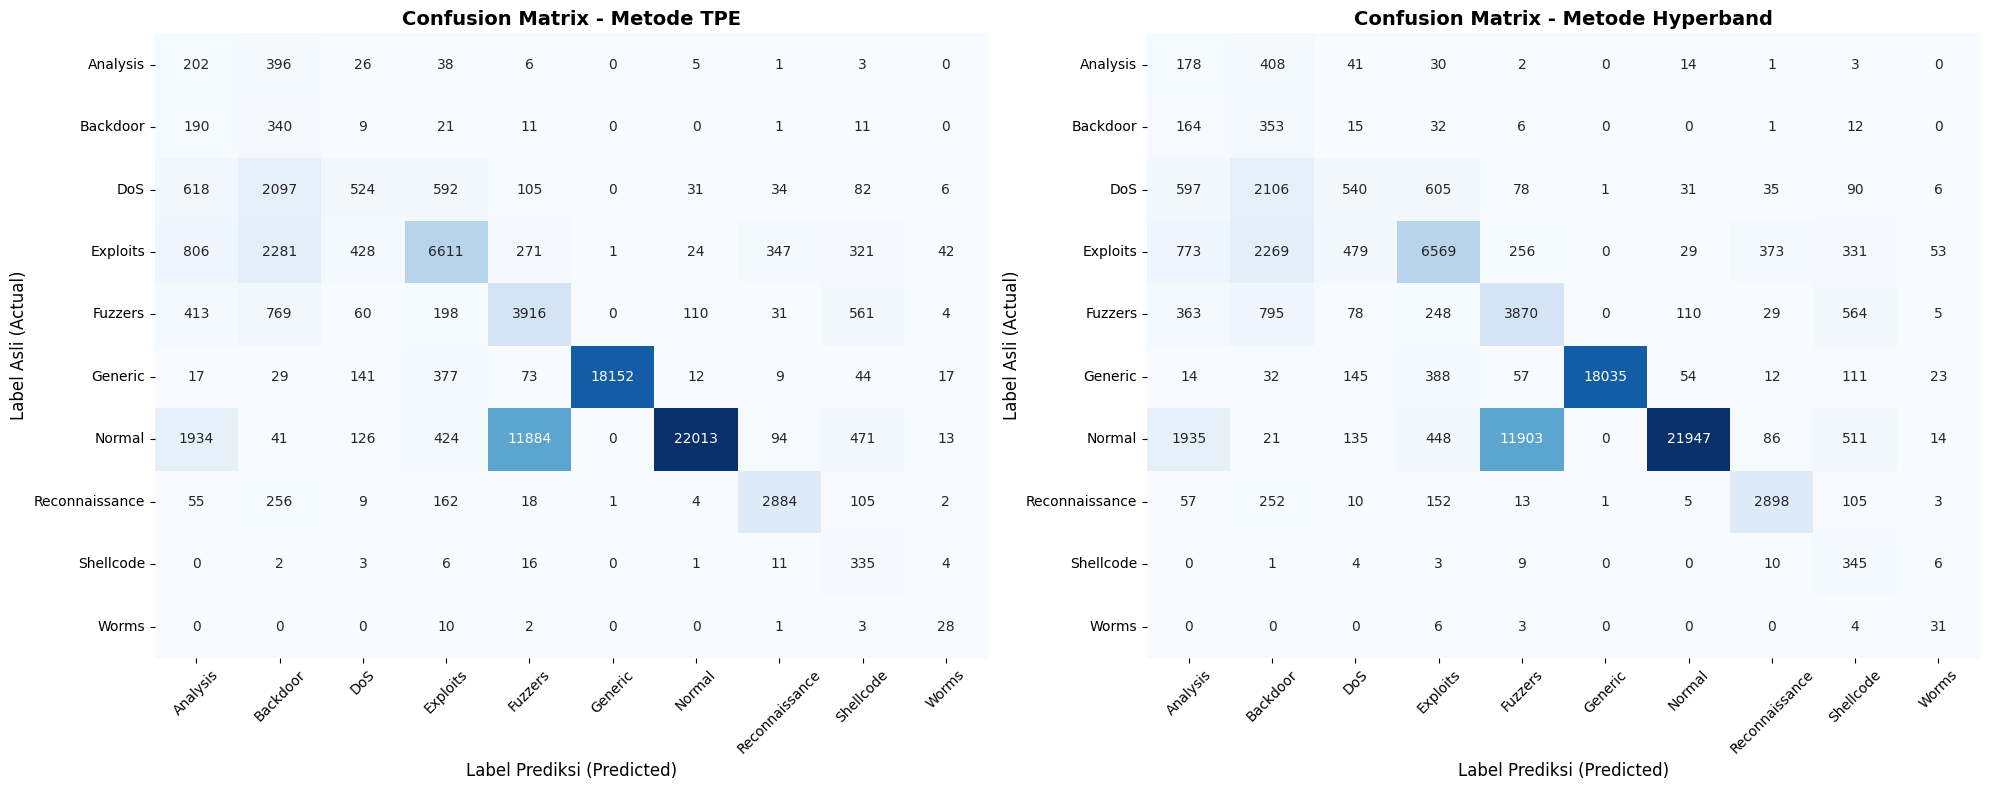

In [37]:
# Cell 14: Visualisasi Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Fungsi untuk plot confusion matrix agar rapi
def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)

    # Menggunakan label kelas asli (bukan angka 0-9)
    class_names = le_target.classes_

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Label Asli (Actual)', fontsize=12)
    ax.set_xlabel('Label Prediksi (Predicted)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

# Siapkan Canvas
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Plot TPE
plot_cm(y_test, y_pred_tpe, "Confusion Matrix - Metode TPE", axes[0])

# 2. Plot Hyperband
plot_cm(y_test, y_pred_hb, "Confusion Matrix - Metode Hyperband", axes[1])

plt.tight_layout()
plt.show()

In [38]:
# Cell 12: Tabel Perbandingan Akhir
def get_stats(study):
    df = study.trials_dataframe()
    total_time = (df['datetime_complete'].max() - df['datetime_start'].min()).total_seconds()
    best_trial = study.best_trial.number
    pruned = len(df[df['state'] == 'PRUNED'])
    return total_time, best_trial, pruned

t_tpe, b_tpe, p_tpe = get_stats(study_tpe)
t_hb, b_hb, p_hb = get_stats(study_hb)

df_compare = pd.DataFrame({
    'Metode': ['TPE', 'Hyperband'],
    'Macro F1-Score': [f1_tpe, f1_hb],
    'Waktu Optimasi (detik)': [t_tpe, t_hb],
    'Konvergensi (Best Trial)': [b_tpe, b_hb],
    'Trial Dipangkas (Pruned)': [p_tpe, p_hb]
})

print("\n=== HASIL AKHIR KOMPARASI ===")
display(df_compare)


=== HASIL AKHIR KOMPARASI ===


,Metode,Macro F1-Score,Waktu Optimasi (detik),Konvergensi (Best Trial),Trial Dipangkas (Pruned)
0,TPE,0.460027,1395.526981,28,0
1,Hyperband,0.456123,1132.751434,23,20


#Save Model

In [39]:
# Cell 15: Menyimpan Model ke File
import os

# Tentukan folder penyimpanan (Gunakan folder dataset Anda agar aman)
# Pastikan path ini sesuai dengan yang Anda set di Cell 2
save_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/'

# Cek apakah folder ada, jika tidak buat baru (jaga-jaga)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# 1. Simpan Model TPE
path_tpe = os.path.join(save_folder, 'model_final_tpe.cbm')
final_model_tpe.save_model(path_tpe)
print(f"✅ Model TPE berhasil disimpan di: {path_tpe}")

# 2. Simpan Model Hyperband
path_hb = os.path.join(save_folder, 'model_final_hyperband.cbm')
final_model_hb.save_model(path_hb)
print(f"✅ Model Hyperband berhasil disimpan di: {path_hb}")

✅ Model TPE berhasil disimpan di: /content/drive/MyDrive/Colab Notebooks/Dataset/model_final_tpe.cbm
✅ Model Hyperband berhasil disimpan di: /content/drive/MyDrive/Colab Notebooks/Dataset/model_final_hyperband.cbm


#VISUALISASI

/tmp/ipython-input-3755330019.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp_top, palette='viridis')


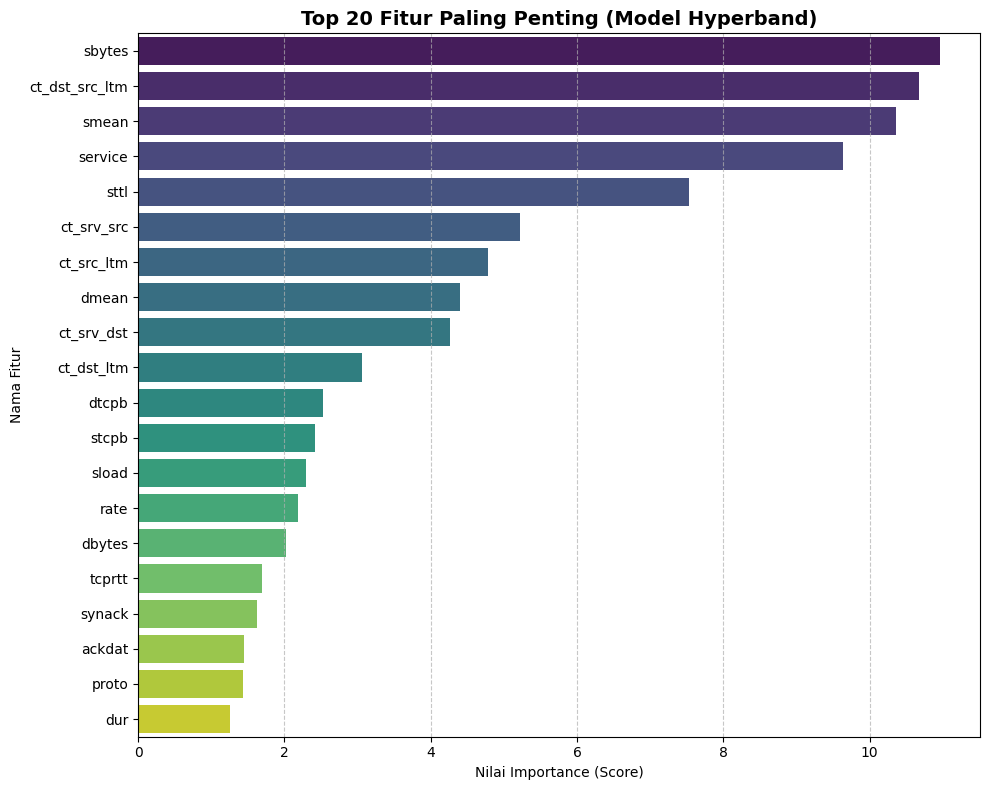

Detail Feature Importance:


,Feature,Importance
6,sbytes,10.960182
35,ct_dst_src_ltm,10.669355
26,smean,10.353609
2,service,9.640753
9,sttl,7.527521
30,ct_srv_src,5.222403
39,ct_src_ltm,4.781710
27,dmean,4.404225
40,ct_srv_dst,4.264677
32,ct_dst_ltm,3.059511


In [40]:
# Cell Tambahan: Visualisasi Feature Importance (Ambil dari Model Hyperband)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names):
    # Ambil nilai importance
    feature_importances = model.get_feature_importance()

    # Buat DataFrame
    df_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Ambil Top 20 Fitur saja agar grafik tidak penuh
    df_imp_top = df_imp.head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=df_imp_top, palette='viridis')
    plt.title('Top 20 Fitur Paling Penting (Model Hyperband)', fontsize=14, fontweight='bold')
    plt.xlabel('Nilai Importance (Score)')
    plt.ylabel('Nama Fitur')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df_imp

# Panggil fungsi (Gunakan nama kolom dari X_train_enc)
# Pastikan X_train_enc masih ada di memori
feature_names = X_train_enc.columns.tolist()
df_importance = plot_feature_importance(final_model_hb, feature_names)

# Tampilkan tabelnya juga
print("Detail Feature Importance:")
display(df_importance.head(10))

In [41]:
# Cell Tambahan: Visualisasi Riwayat Optimasi Optuna
from optuna.visualization import plot_optimization_history

# 1. Plot History TPE
print("Visualisasi Proses Optimasi TPE:")
fig_tpe = plot_optimization_history(study_tpe)
fig_tpe.update_layout(title_text="Riwayat Optimasi - Metode TPE")
fig_tpe.show()

# 2. Plot History Hyperband
print("\nVisualisasi Proses Optimasi Hyperband:")
fig_hb = plot_optimization_history(study_hb)
fig_hb.update_layout(title_text="Riwayat Optimasi - Metode Hyperband")
fig_hb.show()

Visualisasi Proses Optimasi TPE:



Visualisasi Proses Optimasi Hyperband:


In [42]:
# Cell Tambahan: Visualisasi Kepentingan Hyperparameter
from optuna.visualization import plot_param_importances

# Kita lihat dari study Hyperband saja (karena ini model jagoan Anda)
print("Analisis Sensitivitas Parameter (Hyperband Study):")
fig_param = plot_param_importances(study_hb)
fig_param.update_layout(title_text="Hyperparameter Importance - Hyperband")
fig_param.show()

Analisis Sensitivitas Parameter (Hyperband Study):


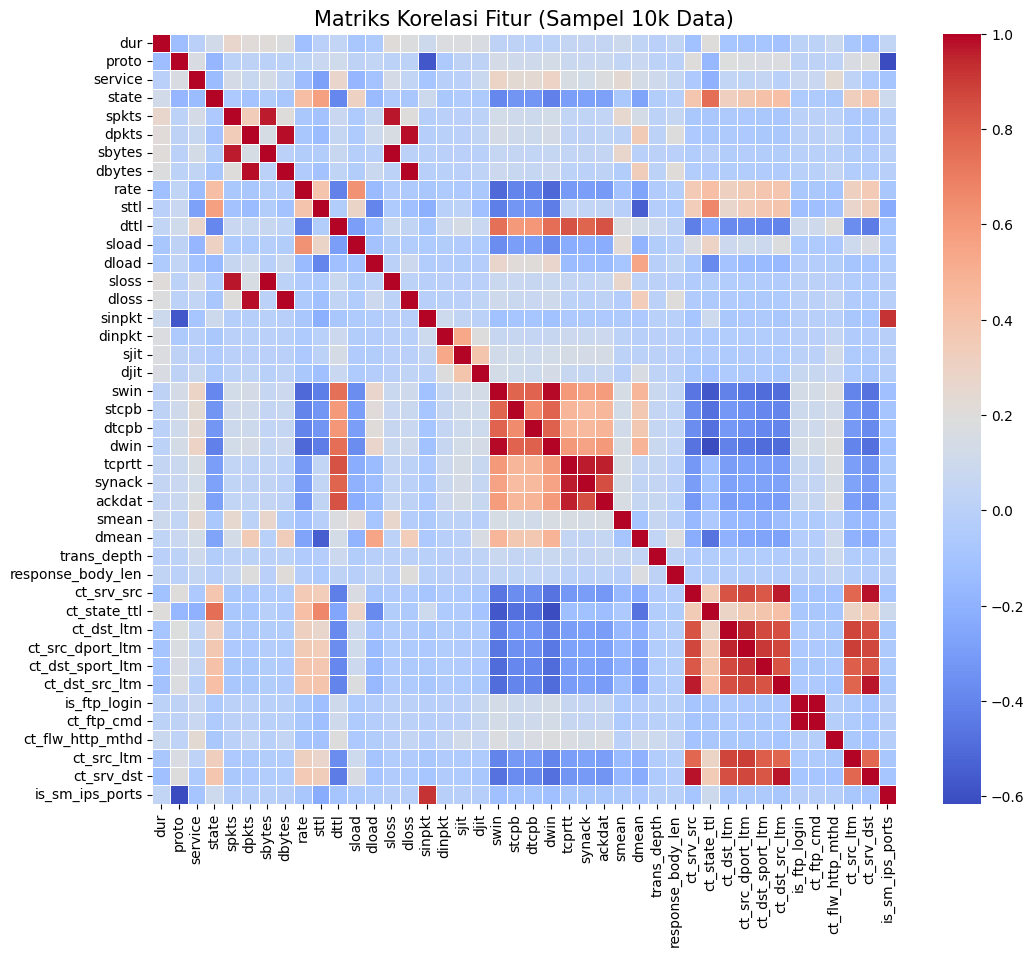

In [43]:
# Cell Tambahan A (Setelah Cell 5): Matriks Korelasi
import seaborn as sns
import matplotlib.pyplot as plt

# Gunakan sampel data agar plotting tidak berat (misal 10.000 baris)
# Kita ambil dari X_train_enc yang sudah di-encode
df_corr_sample = X_train_enc.sample(n=10000, random_state=42)

plt.figure(figsize=(12, 10))
# Hitung korelasi
corr_matrix = df_corr_sample.corr()

# Plot Heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriks Korelasi Fitur (Sampel 10k Data)', fontsize=15)
plt.show()

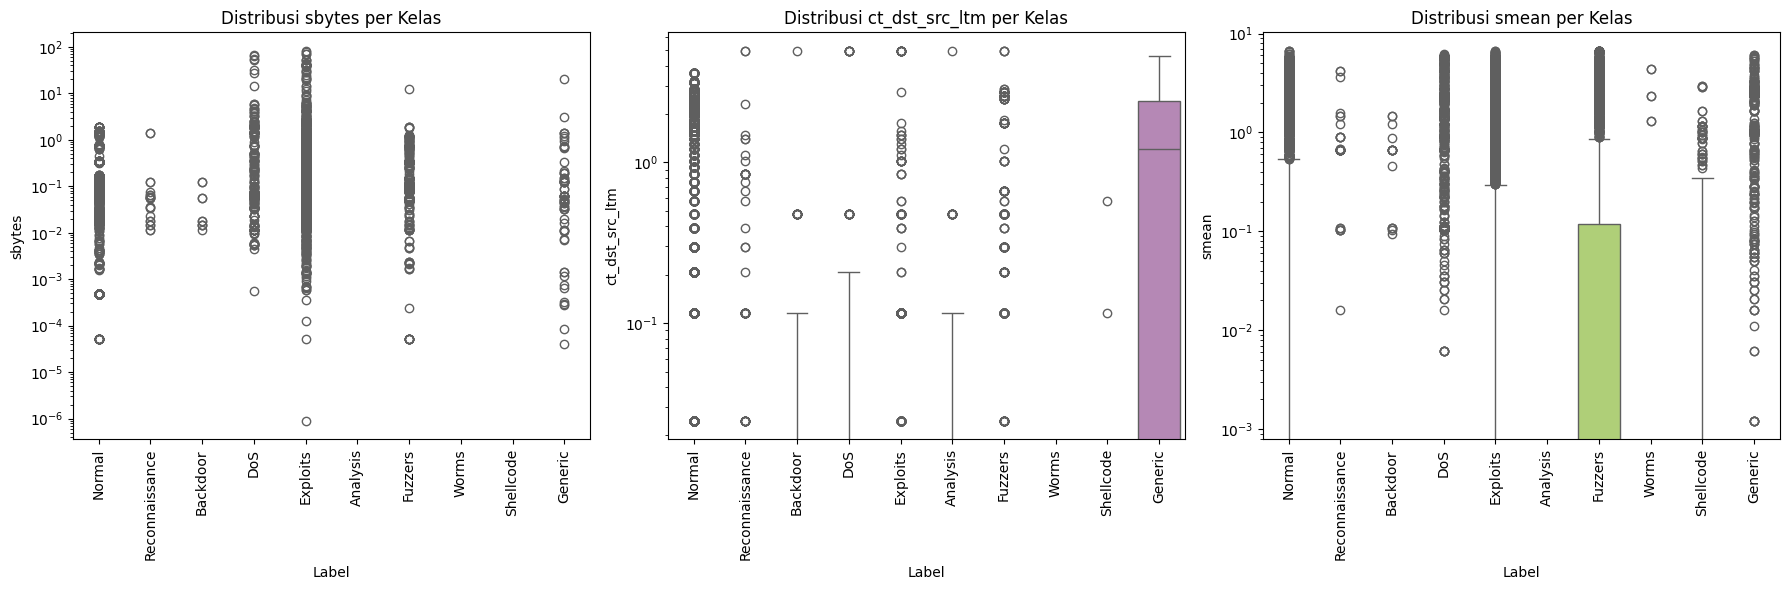

In [46]:
# Cell Tambahan B (Revisi): Boxplot Fitur Utama
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ambil 3 Fitur Paling Penting dari model Hyperband
# (Pastikan Anda sudah menjalankan kode Feature Importance sebelumnya)
if 'df_importance' in locals():
    top_3_features = df_importance['Feature'].head(3).tolist()
else:
    # Fallback jika belum run feature importance, kita ambil 3 kolom pertama
    top_3_features = X_test_enc.columns[:3].tolist()

# 2. Siapkan data untuk plot
df_viz = X_test_enc.copy()
df_viz['attack_cat'] = y_test
# Decode label angka kembali ke nama asli agar grafik mudah dibaca
df_viz['Label'] = le_target.inverse_transform(df_viz['attack_cat'])

# 3. Buat Boxplot
plt.figure(figsize=(18, 6)) # Saya perlebar sedikit agar tulisan tidak tumpang tindih

for i, feature in enumerate(top_3_features):
    plt.subplot(1, 3, i+1)

    # PERBAIKAN DI SINI: Menambahkan hue='Label' dan legend=False
    sns.boxplot(
        data=df_viz,
        x='Label',
        y=feature,
        hue='Label',      # Warna mengikuti Label
        legend=False,     # Matikan legend duplikat
        palette='Set3'
    )

    plt.xticks(rotation=90)
    plt.title(f'Distribusi {feature} per Kelas')
    plt.yscale('log') # Log scale agar outlier terlihat jelas

plt.tight_layout()
plt.show()

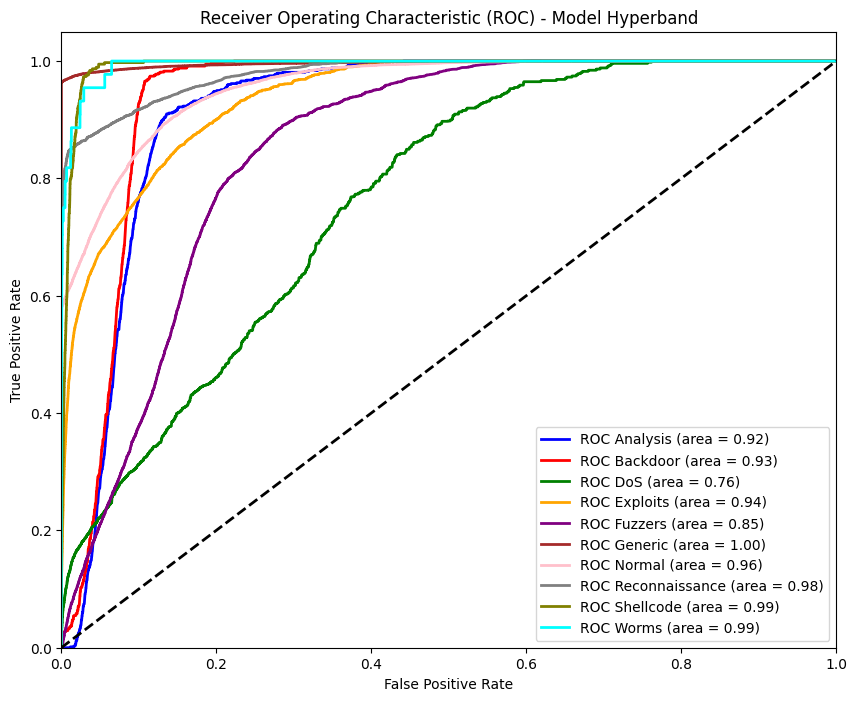

In [45]:
# Cell Tambahan C (Evaluasi Akhir): Kurva ROC-AUC Multi-kelas
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. Siapkan Data
# Binarize label (mengubah y_test jadi format binary per kelas)
y_test_bin = label_binarize(y_test, classes=range(len(le_target.classes_)))
n_classes = y_test_bin.shape[1]

# Prediksi Probabilitas (bukan label 0/1, tapi % keyakinan model)
y_score = final_model_hb.predict_proba(X_test_enc)

# 2. Hitung ROC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot Kurva
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC {0} (area = {1:0.2f})'.format(le_target.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Garis diagonal (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Model Hyperband')
plt.legend(loc="lower right")
plt.show()

/tmp/ipython-input-1317479954.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Sedang menghitung t-SNE untuk 3000 titik data... (Mohon tunggu)


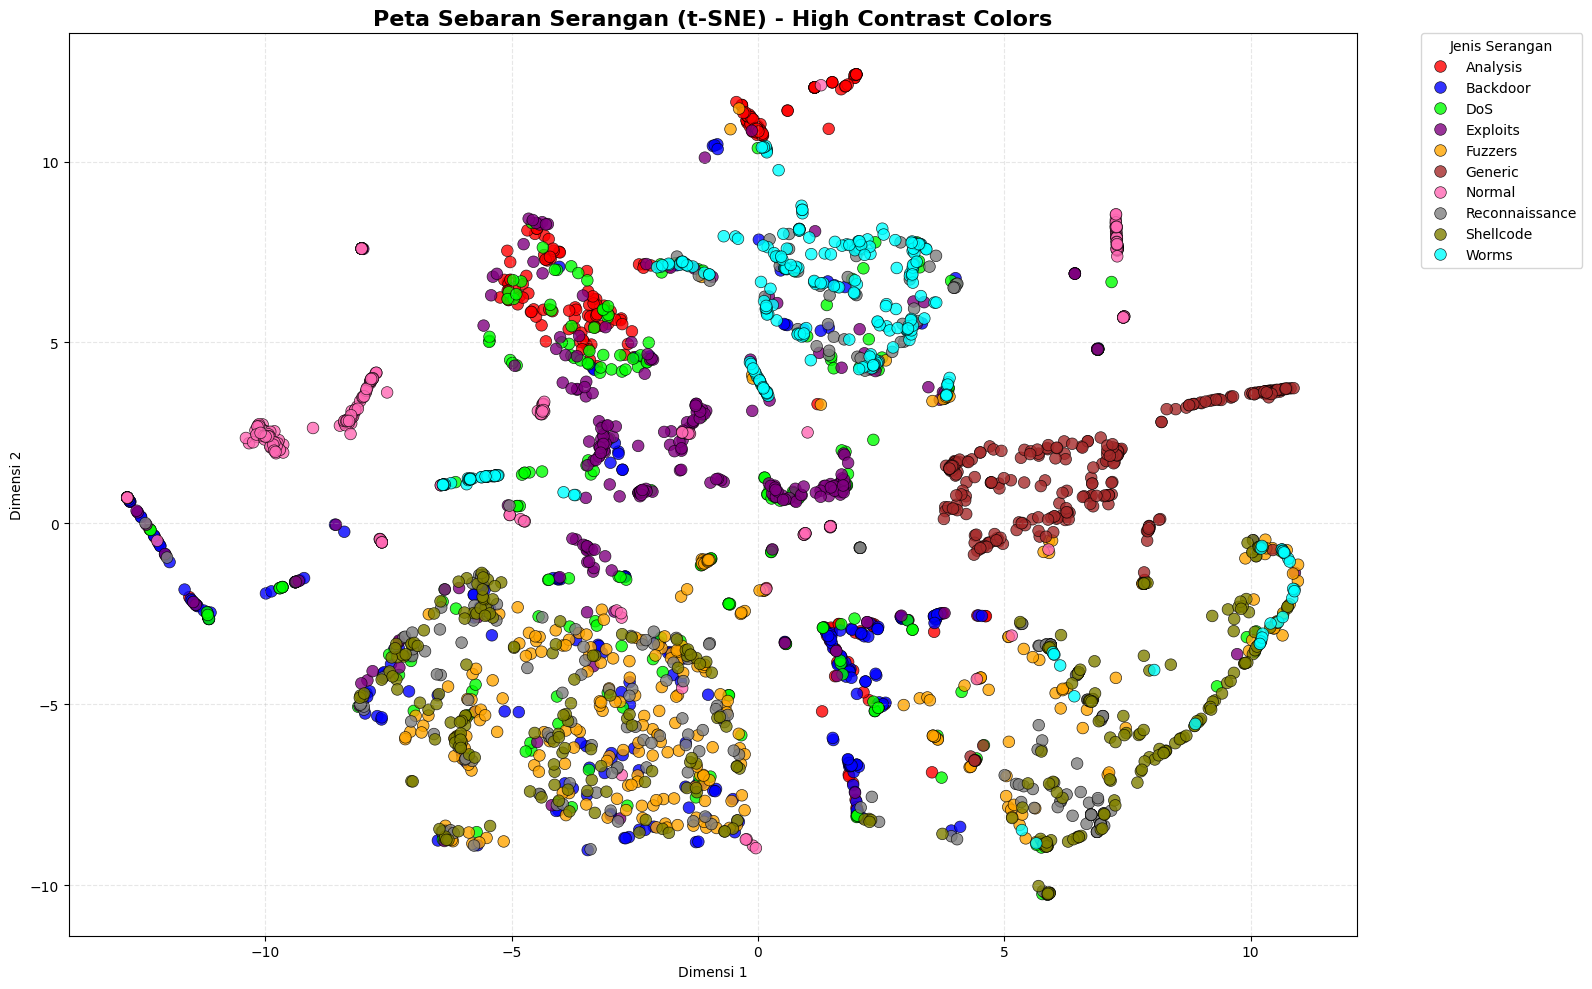

In [49]:
# Cell Tambahan D (Revisi): Visualisasi Sebaran Data 2D dengan t-SNE (Warna High Contrast)
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Sampling Data (Tetap 3000 agar tidak berat)
n_samples = 3000
df_sample = X_train_resampled.copy()
df_sample['attack_cat'] = y_train_resampled

# Stratified Sampling
try:
    df_vis = df_sample.groupby('attack_cat', group_keys=False).apply(
        lambda x: x.sample(min(len(x), int(n_samples / len(le_target.classes_))))
    )
except:
    df_vis = df_sample.sample(n=n_samples, random_state=42)

# Pisahkan X dan y
X_vis = df_vis.drop(columns=['attack_cat'])
y_vis = df_vis['attack_cat']
y_vis_names = le_target.inverse_transform(y_vis)

print(f"Sedang menghitung t-SNE untuk {len(X_vis)} titik data... (Mohon tunggu)")

# 2. Hitung t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_vis)

# 3. Buat DataFrame
df_tsne = pd.DataFrame({
    'tsne_2d_one': tsne_results[:, 0],
    'tsne_2d_two': tsne_results[:, 1],
    'Label': y_vis_names
})

# --- REVISI UTAMA: PALET WARNA MANUAL (HIGH CONTRAST) ---
# Urutan warna ini dipilih agar saling bertolak belakang
custom_palette = [
    "#FF0000", # Merah Terang
    "#0000FF", # Biru Terang
    "#00FF00", # Hijau Neon
    "#800080", # Ungu Gelap
    "#FFA500", # Oranye
    "#A52A2A", # Coklat
    "#FF69B4", # Pink
    "#808080", # Abu-abu
    "#808000", # Zaitun (Olive)
    "#00FFFF"  # Cyan/Biru Muda
]
# Pastikan jumlah warna cukup untuk jumlah kelas
if len(le_target.classes_) > 10:
    custom_palette = sns.color_palette("tab20", len(le_target.classes_)) # Fallback jika kelas > 10

# 4. Plotting dengan Warna Baru
plt.figure(figsize=(16, 10))

sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="Label",
    palette=sns.color_palette(custom_palette), # Gunakan palet manual kita
    data=df_tsne,
    legend="full",
    alpha=0.8,  # Sedikit lebih solid agar warna menonjol
    s=70,       # Titik sedikit diperbesar
    edgecolor='black', # Garis pinggir hitam agar titik makin jelas
    linewidth=0.5
)

plt.title('Peta Sebaran Serangan (t-SNE) - High Contrast Colors', fontsize=16, fontweight='bold')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Jenis Serangan")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()